V17: add TTA

# load packages

In [1]:
import os
from skimage.data import imread
from skimage.morphology import label
import pandas as pd
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

input_dir = '/home/cpadwick/data/airbus_ships/'
train_img_dir = '/home/cpadwick/data/airbus_ships/train/'
test_img_dir = '/home/cpadwick/data/airbus_ships/test/'

Using TensorFlow backend.


# load train_dataframe

In [2]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations_v2.csv')

In [3]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
train_df.shape

(231723, 2)

# remove bug images

In [5]:
train_df = train_df[train_df['ImageId'] != '6384c3e78.jpg']

In [6]:
train_df.shape

(231722, 2)

# remove 100000 non-ship images

In [7]:
def area_isnull(x):
    if x == x:
        return 0
    else:
        return 1

In [8]:
train_df['isnan'] = train_df['EncodedPixels'].apply(area_isnull)

In [9]:
train_df['isnan'].value_counts()

1    149999
0     81723
Name: isnan, dtype: int64

In [10]:
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[100000:]

In [11]:
train_df['isnan'].value_counts()

0    81723
1    49999
Name: isnan, dtype: int64

# calculate ship area and group by ImageId

In [12]:
def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [13]:
def calc_area_for_rle(rle_str):
    rle_list = [int(x) if x.isdigit() else x for x in str(rle_str).split()]
    if len(rle_list) == 1:
        return 0
    else:
        area = np.sum(rle_list[1::2])
        return area

In [14]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

get small area of one ship; If estimated area of the ship is less than 10, it is corrected to 0.

In [15]:
train_df_isship = train_df[train_df['area'] > 0]

In [16]:
train_df_isship.shape

(81723, 4)

In [17]:
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]

In [18]:
train_df_smallarea.shape

(101,)

In [19]:
train_df_smallarea.shape[0]/train_df_isship.shape[0]

0.001235882187389107

In [20]:
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()

In [21]:
train_gp.head()

,ImageId,isnan,area
0,000155de5.jpg,0,3388
1,000194a2d.jpg,0,1460
2,0001b1832.jpg,1,0
3,00021ddc3.jpg,0,1176
4,0002756f7.jpg,0,408


# set class of ship area

In [22]:
def calc_class(area):
    area = area / (768*768)
    if area == 0:
        return 0
    elif area < 0.005:
        return 1
    elif area < 0.015:
        return 2
    elif area < 0.025:
        return 3
    elif area < 0.035:
        return 4
    elif area < 0.045:
        return 5
    else:
        return 6

In [23]:
train_gp['class'] = train_gp['area'].apply(calc_class)

In [24]:
train_gp['class'].value_counts()

0    49999
1    29315
2     9225
3     2644
4     1122
5      181
6       69
Name: class, dtype: int64

# split train-set and validation-set (stratified: area class)

In [25]:
train, val = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [26]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

val_isship_list = val['ImageId'][val['isnan']==0].tolist()
val_nanship_list = val['ImageId'][val['isnan']==1].tolist()

In [27]:
len(train_isship_list),len(train_nanship_list)

(42130, 49499)

# create data generator
Make the ratio of is-ship images and nan-ship images  equal

In [28]:
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)
    
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def mygenerator(isship_list, nanship_list, batch_size, cap_num):
    train_img_names_nanship = isship_list[:cap_num]
    train_img_names_isship = nanship_list[:cap_num]
    k = 0
    while True:
        if k+batch_size//2 >= cap_num:
            k = 0
        batch_img_names_nan = train_img_names_nanship[k:k+batch_size//2]
        batch_img_names_is = train_img_names_isship[k:k+batch_size//2]
        batch_img = []
        batch_mask = []
        for name in batch_img_names_nan:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        for name in batch_img_names_is:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        img = np.stack(batch_img, axis=0)
        mask = np.stack(batch_mask, axis=0)
        img = img / 255.0
        mask = mask / 255.0
        k += batch_size//2
        yield img, mask

In [29]:
BATCH_SIZE = 16
CAP_NUM = min(len(train_isship_list),len(train_nanship_list))
datagen = mygenerator(train_isship_list, train_nanship_list, batch_size=BATCH_SIZE, cap_num=CAP_NUM)

valgen = mygenerator(val_isship_list, val_nanship_list, batch_size=50, cap_num=CAP_NUM)

numvalimages = 50
val_x, val_y = next(valgen)


# set model
U-net with Hypercolumn

In [30]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)

#from keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [32]:
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import math, shutil

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.7, 
                                   patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)

if os.path.exists('./log'):
    shutil.rmtree('./log')

tb_callback = TensorBoard(log_dir='./log', histogram_freq=0,  
          write_graph=True, write_images=True)

callbacks_list = [tb_callback, reduceLROnPlat]

NUM_EPOCHS = 500

model.compile(optimizer=Adam(1e-3, decay=0.0), loss=IoU, metrics=['binary_accuracy'])

/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# training

In [33]:
history = model.fit_generator(datagen, steps_per_epoch = 250, epochs = NUM_EPOCHS, callbacks=callbacks_list,
                             validation_data=(val_x, val_y), workers=4)

Epoch 1/500
250/250 [==============================] - 487s 2s/step - loss: -0.0441 - binary_accuracy: 0.4280 - val_loss: -0.0884 - val_binary_accuracy: 0.5959
Epoch 2/500
250/250 [==============================] - 478s 2s/step - loss: -0.0995 - binary_accuracy: 0.6081 - val_loss: -0.0918 - val_binary_accuracy: 0.7463
Epoch 3/500
250/250 [==============================] - 465s 2s/step - loss: -0.1209 - binary_accuracy: 0.6983 - val_loss: -0.1097 - val_binary_accuracy: 0.7809
Epoch 4/500
250/250 [==============================] - 470s 2s/step - loss: -0.1351 - binary_accuracy: 0.8167 - val_loss: -0.1158 - val_binary_accuracy: 0.8480
Epoch 5/500
250/250 [==============================] - 467s 2s/step - loss: -0.1445 - binary_accuracy: 0.8738 - val_loss: -0.1217 - val_binary_accuracy: 0.9370
Epoch 6/500
250/250 [==============================] - 473s 2s/step - loss: -0.1570 - binary_accuracy: 0.8820 - val_loss: -0.1423 - val_binary_accuracy: 0.9426
Epoch 7/500
250/250 [===================

Epoch 50/500
250/250 [==============================] - 464s 2s/step - loss: -0.2954 - binary_accuracy: 0.9981 - val_loss: -0.3343 - val_binary_accuracy: 0.9950
Epoch 51/500
250/250 [==============================] - 462s 2s/step - loss: -0.4271 - binary_accuracy: 0.9979 - val_loss: -0.4013 - val_binary_accuracy: 0.9956
Epoch 52/500
250/250 [==============================] - 473s 2s/step - loss: -0.5398 - binary_accuracy: 0.9973 - val_loss: -0.3936 - val_binary_accuracy: 0.9948
Epoch 53/500
250/250 [==============================] - 474s 2s/step - loss: -0.6034 - binary_accuracy: 0.9976 - val_loss: -0.4904 - val_binary_accuracy: 0.9977
Epoch 54/500
250/250 [==============================] - 476s 2s/step - loss: -0.6081 - binary_accuracy: 0.9976 - val_loss: -0.5706 - val_binary_accuracy: 0.9976
Epoch 55/500
250/250 [==============================] - 473s 2s/step - loss: -0.6187 - binary_accuracy: 0.9974 - val_loss: -0.5704 - val_binary_accuracy: 0.9979

Epoch 00055: ReduceLROnPlateau re

Epoch 99/500
250/250 [==============================] - 470s 2s/step - loss: -0.6829 - binary_accuracy: 0.9982 - val_loss: -0.6022 - val_binary_accuracy: 0.9983

Epoch 00099: ReduceLROnPlateau reducing learning rate to 4.0353603617404586e-05.
Epoch 100/500
250/250 [==============================] - 467s 2s/step - loss: -0.6801 - binary_accuracy: 0.9983 - val_loss: -0.6052 - val_binary_accuracy: 0.9982
Epoch 101/500
250/250 [==============================] - 476s 2s/step - loss: -0.6873 - binary_accuracy: 0.9983 - val_loss: -0.5794 - val_binary_accuracy: 0.9982
Epoch 102/500
250/250 [==============================] - 472s 2s/step - loss: -0.6890 - binary_accuracy: 0.9983 - val_loss: -0.6397 - val_binary_accuracy: 0.9983
Epoch 103/500
250/250 [==============================] - 482s 2s/step - loss: -0.6850 - binary_accuracy: 0.9982 - val_loss: -0.6212 - val_binary_accuracy: 0.9982
Epoch 104/500
250/250 [==============================] - 474s 2s/step - loss: -0.6797 - binary_accuracy: 0.99

250/250 [==============================] - 467s 2s/step - loss: -0.6885 - binary_accuracy: 0.9984 - val_loss: -0.5711 - val_binary_accuracy: 0.9980
Epoch 148/500
250/250 [==============================] - 476s 2s/step - loss: -0.6860 - binary_accuracy: 0.9984 - val_loss: -0.5808 - val_binary_accuracy: 0.9981
Epoch 149/500
250/250 [==============================] - 466s 2s/step - loss: -0.6867 - binary_accuracy: 0.9983 - val_loss: -0.5863 - val_binary_accuracy: 0.9981
Epoch 150/500
250/250 [==============================] - 473s 2s/step - loss: -0.6808 - binary_accuracy: 0.9983 - val_loss: -0.5842 - val_binary_accuracy: 0.9981
Epoch 151/500
250/250 [==============================] - 468s 2s/step - loss: -0.6942 - binary_accuracy: 0.9983 - val_loss: -0.5681 - val_binary_accuracy: 0.9980
Epoch 152/500
250/250 [==============================] - 469s 2s/step - loss: -0.6855 - binary_accuracy: 0.9984 - val_loss: -0.5843 - val_binary_accuracy: 0.9981
Epoch 153/500
250/250 [===================

250/250 [==============================] - 486s 2s/step - loss: -0.6967 - binary_accuracy: 0.9983 - val_loss: -0.5893 - val_binary_accuracy: 0.9982
Epoch 196/500
250/250 [==============================] - 486s 2s/step - loss: -0.6895 - binary_accuracy: 0.9983 - val_loss: -0.5873 - val_binary_accuracy: 0.9982
Epoch 197/500
250/250 [==============================] - 486s 2s/step - loss: -0.6991 - binary_accuracy: 0.9984 - val_loss: -0.6031 - val_binary_accuracy: 0.9982
Epoch 198/500
250/250 [==============================] - 482s 2s/step - loss: -0.6894 - binary_accuracy: 0.9983 - val_loss: -0.6080 - val_binary_accuracy: 0.9982

Epoch 00198: ReduceLROnPlateau reducing learning rate to 1.6284134062516385e-06.
Epoch 199/500
250/250 [==============================] - 495s 2s/step - loss: -0.6966 - binary_accuracy: 0.9984 - val_loss: -0.5900 - val_binary_accuracy: 0.9982
Epoch 200/500
250/250 [==============================] - 479s 2s/step - loss: -0.6946 - binary_accuracy: 0.9984 - val_loss

250/250 [==============================] - 689s 3s/step - loss: -0.6844 - binary_accuracy: 0.9983 - val_loss: -0.5892 - val_binary_accuracy: 0.9981
Epoch 245/500
250/250 [==============================] - 686s 3s/step - loss: -0.6882 - binary_accuracy: 0.9982 - val_loss: -0.5729 - val_binary_accuracy: 0.9982
Epoch 246/500
250/250 [==============================] - 670s 3s/step - loss: -0.6933 - binary_accuracy: 0.9984 - val_loss: -0.5819 - val_binary_accuracy: 0.9981
Epoch 247/500
250/250 [==============================] - 649s 3s/step - loss: -0.6795 - binary_accuracy: 0.9984 - val_loss: -0.5886 - val_binary_accuracy: 0.9981
Epoch 248/500
250/250 [==============================] - 691s 3s/step - loss: -0.6955 - binary_accuracy: 0.9984 - val_loss: -0.5890 - val_binary_accuracy: 0.9982
Epoch 249/500
250/250 [==============================] - 675s 3s/step - loss: -0.6960 - binary_accuracy: 0.9984 - val_loss: -0.5849 - val_binary_accuracy: 0.9982
Epoch 250/500
250/250 [===================

250/250 [==============================] - 639s 3s/step - loss: -0.6892 - binary_accuracy: 0.9983 - val_loss: -0.5832 - val_binary_accuracy: 0.9980
Epoch 295/500
250/250 [==============================] - 642s 3s/step - loss: -0.6876 - binary_accuracy: 0.9984 - val_loss: -0.5891 - val_binary_accuracy: 0.9981
Epoch 296/500
250/250 [==============================] - 667s 3s/step - loss: -0.6892 - binary_accuracy: 0.9984 - val_loss: -0.5690 - val_binary_accuracy: 0.9982
Epoch 297/500
250/250 [==============================] - 682s 3s/step - loss: -0.6837 - binary_accuracy: 0.9982 - val_loss: -0.5876 - val_binary_accuracy: 0.9981
Epoch 298/500
250/250 [==============================] - 624s 2s/step - loss: -0.6879 - binary_accuracy: 0.9983 - val_loss: -0.5790 - val_binary_accuracy: 0.9980
Epoch 299/500
250/250 [==============================] - 615s 2s/step - loss: -0.6928 - binary_accuracy: 0.9984 - val_loss: -0.5856 - val_binary_accuracy: 0.9981
Epoch 300/500
250/250 [===================

KeyboardInterrupt: 

In [ ]:
#epoch = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in history]))
#plt.plot(epoch, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-')

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_history(history)

In [34]:
#with open('seg_model_hypercolumn.json', 'w')
#model.to_json('seg_model_hypercolumn.json')
model.save('seg_model_hypercolumn.h5')
#model.save_weights('weights.h5')

In [35]:
tt = model.predict(val_x)

In [36]:
np.max(tt)


1.0

# calculate F2 score for validation set

- set  function of caluculating  score

In [37]:
def calc_IoU(A, B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

In [38]:
def calc_IoU_vector(A, B):
    score_vector = []
    IoU = calc_IoU(A, B)
    for threshold in np.arange(0.5,1,0.05):
        score = int(IoU > threshold)
        score_vector.append(score)
    return score_vector

In [39]:
def calc_IoU_tensor(masks_true, masks_pred):
    true_mask_num = masks_true.shape[0]
    pred_mask_num = masks_pred.shape[0]
    score_tensor = np.zeros((true_mask_num, pred_mask_num, 10))
    for true_i in range(true_mask_num):
        for pred_i in range(pred_mask_num):
            true_mask = masks_true[true_i]
            pred_mask = masks_pred[pred_i]
            score_vector = calc_IoU_vector(true_mask, pred_mask)
            score_tensor[true_i,pred_i,:] = score_vector
    return score_tensor

In [40]:
def calc_F2_per_one_threshold(score_matrix):
    tp = np.sum( score_matrix.sum(axis=1) > 0  )
    fp = np.sum( score_matrix.sum(axis=1) == 0 )
    fn = np.sum( score_matrix.sum(axis=0) == 0 )
    F2 = (5*tp) / ((5*tp) + fp + (4*fn))
    return F2

In [41]:
def calc_score_one_image(mask_true, mask_pred):
    mask_true = mask_true.reshape(768,768)
    mask_pred = mask_pred.reshape(768,768)
    if mask_true.sum() == 0 and mask_pred.sum() == 0:
        score = 1
    elif mask_true.sum() == 0 and mask_pred.sum() != 0:
        score = 0
    elif mask_true.sum() != 0 and mask_pred.sum() == 0:
        score = 0
    else:
        mask_label_true = label(mask_true)
        mask_label_pred = label(mask_pred)
        c_true = np.max(mask_label_true)
        c_pred = np.max(mask_label_pred)
        tmp = []
        for k in range(c_true):
            tmp.append(mask_label_true == k+1)
        masks_true = np.stack(tmp, axis=0)
        tmp = []
        for k in range(c_pred):
            tmp.append(mask_label_pred == k+1)
        masks_pred = np.stack(tmp, axis=0)
        score_tensor = calc_IoU_tensor(masks_true, masks_pred)
        F2_t = []
        for i in range(10):
            F2 = calc_F2_per_one_threshold(score_tensor[:,:,i])
            F2_t.append(F2)
        score = np.mean(F2_t)
    return score

In [42]:
def calc_score_all_image(batch_mask_true, batch_mask_pred, threshold=0.5):
    num = batch_mask_true.shape[0]
    tmp = batch_mask_pred > threshold
    batch_mask_pred = tmp.astype('int')
    scores = list()
    for i in range(num):
        score = calc_score_one_image(batch_mask_true[i], batch_mask_pred[i])
        scores.append(score)
    return np.mean(scores)

- set validation data

In [43]:
val_list = val['ImageId'].tolist()

In [44]:
def create_data(image_list):
    batch_img = []
    batch_mask = []
    for name in image_list:
        tmp_img = imread(train_img_dir + name)
        batch_img.append(tmp_img)
        mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
        one_mask = np.zeros((768, 768, 1))
        for item in mask_list:
            rle_list = str(item).split()
            tmp_mask = rle_to_mask(rle_list, (768, 768))
            one_mask[:,:,0] += tmp_mask
        batch_mask.append(one_mask)
    img = np.stack(batch_img, axis=0)
    mask = np.stack(batch_mask, axis=0)
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

- put it together and search optimal threshold

In [47]:
from tqdm import tqdm

In [48]:
#search threshold
scores_list = dict()
threshold_list = [x/100 for x in range(20,80,10)]
for threshold in threshold_list:
    scores = []
    for i in tqdm(range(len(val_list)//2)):
        temp_list = val_list[i*2:(i+1)*2]
        val_img, val_mask = create_data(temp_list)
        pred_mask = model.predict(val_img)
        F2 = calc_score_all_image(val_mask, pred_mask, threshold=threshold)*2
        scores.append(F2)
    val_F2 = np.sum(scores)/(len(val_list)//2 *2)
    scores_list[threshold] = val_F2

100%|██████████| 463/463 [01:32<00:00,  5.38it/s]


In [49]:
scores_list

{0.2: 0.5855095767970023,
 0.3: 0.5856369454702242,
 0.4: 0.5855056196191948,
 0.5: 0.5853648810398842,
 0.6: 0.5850146765484372,
 0.7: 0.5860093021980546}

In [50]:
opt_threshold = max(scores_list, key=scores_list.get)

# visualize predict images
display 5 images

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
len(val_list)

926

In [53]:
# generate validation image predictions
from skimage.io import imsave
val_dir = './val_images/'
if not os.path.exists(val_dir):
    os.rmdir(val_dir)
    os.mkdir(val_dir)
    
for i in range(len(val_list)):
    img_name = os.path.join(train_img_dir, val_list[i])
    print(val_list[i])
    img = imread(img_name)
    input_img, gt_mask = create_data([val_list[i]])
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask.reshape(768,768,1)
    input_img = input_img.reshape(768, 768, 3)
    input_img = (input_img * 255).astype(np.uint8)
    gt_mask = gt_mask
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    base, ext = os.path.splitext(os.path.basename(img_name))
    out_img = os.path.join(val_dir, os.path.basename(img_name))
    imsave(out_img, input_img * 255)
    out_gt_mask = os.path.join(val_dir, base + '_gt.png')
    imsave(out_gt_mask, gt_mask)
    out_pred_mask = os.path.join(val_dir, base + '_pred.png')
    imsave(out_pred_mask, pred_mask)
    
    
        

29df8e19f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29df8e19f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29df8e19f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


577e82782.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/577e82782_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/577e82782_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fe09d241c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fe09d241c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fe09d241c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0b2a27cc8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b2a27cc8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b2a27cc8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


573add635.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/573add635_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/573add635_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


53f5ddc20.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53f5ddc20.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53f5ddc20_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53f5ddc20_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6b6d2fa13.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6b6d2fa13_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6b6d2fa13_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3b37d608b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b37d608b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b37d608b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


73515bc14.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/73515bc14_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/73515bc14_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


598911b5f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/598911b5f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/598911b5f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


eaf361864.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eaf361864_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eaf361864_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17a453060.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17a453060_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17a453060_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3efc57e29.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3efc57e29_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3efc57e29_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4315030f7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4315030f7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4315030f7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b5983547b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b5983547b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b5983547b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


423a96f82.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/423a96f82_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/423a96f82_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55b1e65df.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55b1e65df_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55b1e65df_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


bf79ee9a8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bf79ee9a8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bf79ee9a8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


117fd20dc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/117fd20dc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/117fd20dc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


bc262d752.jpg
5b2899256.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b2899256_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b2899256_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


618f57c3f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/618f57c3f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/618f57c3f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28d6d9e59.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d6d9e59_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d6d9e59_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


27109dce7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27109dce7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27109dce7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f0f6a35e8.jpg
0ba99c41f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ba99c41f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ba99c41f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e4c332125.jpg
460661ba0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/460661ba0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/460661ba0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0206db0da.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0206db0da_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0206db0da_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0b3feb384.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b3feb384_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b3feb384_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50b05e394.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b05e394_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b05e394_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1c4d207e9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c4d207e9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c4d207e9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3bf45c4fc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3bf45c4fc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3bf45c4fc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


60997c7bd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60997c7bd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60997c7bd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6298aae91.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6298aae91_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6298aae91_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6349fef39.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6349fef39_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6349fef39_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12351fcd9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12351fcd9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12351fcd9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e5f7e094.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e5f7e094_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e5f7e094_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ae0a9f9c6.jpg
fa068302e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fa068302e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


123660fec.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/123660fec_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/123660fec_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d88773293.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d88773293_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d88773293_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


02353a857.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02353a857_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02353a857_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


375d3207f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/375d3207f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b0f4d07ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0f4d07ed.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0f4d07ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0f4d07ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


05e32a19e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05e32a19e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05e32a19e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


701693bc2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/701693bc2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/701693bc2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


954289990.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/954289990_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/954289990_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9e82120ce.jpg
4730aabfc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4730aabfc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4730aabfc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


925ea6e1c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/925ea6e1c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/925ea6e1c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9256ab024.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9256ab024_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9256ab024_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ebca49fdc.jpg
44e90c508.jpg
4f3d613a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f3d613a1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f3d613a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a3808fb96.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3808fb96_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3808fb96_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1f5d236c4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f5d236c4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f5d236c4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15ffdc548.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15ffdc548_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15ffdc548_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


09b51692d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09b51692d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09b51692d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


374609bb2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374609bb2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374609bb2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


27aa19327.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27aa19327.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27aa19327_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27aa19327_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14c3afe87.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14c3afe87_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14c3afe87_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1c834e3ac.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c834e3ac_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c834e3ac_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


60bb6bd3c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60bb6bd3c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60bb6bd3c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36478f88e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36478f88e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36478f88e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0385b9678.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0385b9678_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0385b9678_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e3c07de20.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e3c07de20_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e3c07de20_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


44759ff2d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44759ff2d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44759ff2d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


009363023.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/009363023_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/009363023_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4f81a5c48.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f81a5c48_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f81a5c48_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61e2f57fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61e2f57fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61e2f57fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55d4866c4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55d4866c4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55d4866c4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


092717da0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/092717da0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/092717da0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


535468ae7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/535468ae7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/535468ae7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ddd1e126.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ddd1e126_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ddd1e126_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55ad6e478.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55ad6e478_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55ad6e478_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40bb49a74.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


40bb49a74.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40bb49a74_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40bb49a74_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2055ab290.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2055ab290_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2055ab290_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55fe44265.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55fe44265_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55fe44265_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


22b2d0573.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/22b2d0573_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/22b2d0573_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5657fbe03.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5657fbe03_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5657fbe03_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1f070c57d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f070c57d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f070c57d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16aa6c29e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16aa6c29e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16aa6c29e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5176c5d73.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5176c5d73_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5176c5d73_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4e96627ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e96627ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e96627ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f43c6400.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f43c6400_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f43c6400_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


67f351ed6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/67f351ed6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/67f351ed6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61a8246ec.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61a8246ec_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61a8246ec_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0f0bde82d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f0bde82d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f0bde82d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


48545341d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48545341d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48545341d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48545341d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


30484cd3b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/30484cd3b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


3763f65b8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3763f65b8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3763f65b8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f00c51d7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f00c51d7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f00c51d7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4e37ee262.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e37ee262_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e37ee262_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3b2670645.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b2670645_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b2670645_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d25dd5465.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d25dd5465_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d25dd5465_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cf9dd6e66.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cf9dd6e66_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cf9dd6e66_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e185f5e2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e185f5e2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e185f5e2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e185f5e2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cc26696be.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cc26696be.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cc26696be_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cc26696be_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a2111dd87.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a2111dd87_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a2111dd87_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1ce2f0c7c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ce2f0c7c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ce2f0c7c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


078beb507.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/078beb507.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/078beb507_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/078beb507_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0f955e19d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f955e19d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f955e19d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4b0d04999.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b0d04999_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b0d04999_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f027546a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f027546a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f027546a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e4945819.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e4945819_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e4945819_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f29d1029.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f29d1029_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f29d1029_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36f42791d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36f42791d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36f42791d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3702a893f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3702a893f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3702a893f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3c270c98e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c270c98e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c270c98e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f643eb8f8.jpg
374551f84.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374551f84_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374551f84_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


83d961365.jpg
396a87e13.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/396a87e13_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/396a87e13_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


797426ee9.jpg
2bd91efdc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2bd91efdc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2bd91efdc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f33e2b0f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f33e2b0f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f33e2b0f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ff20a1c5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ff20a1c5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ff20a1c5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


09b07b16d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09b07b16d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09b07b16d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1a3d996ce.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a3d996ce_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a3d996ce_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ebce40c6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ebce40c6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ebce40c6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


021d57a04.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/021d57a04_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/021d57a04_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


60c4f6199.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60c4f6199_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60c4f6199_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e68242572.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e68242572_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e68242572_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d439f2c12.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d439f2c12_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d439f2c12_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


133eeffcf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/133eeffcf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/133eeffcf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e2202d99.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e2202d99_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e2202d99_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


123d017dd.jpg
3de021d2d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3de021d2d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3de021d2d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


56cf143e0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56cf143e0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56cf143e0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9c2fd8e6e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9c2fd8e6e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9c2fd8e6e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4f1eea1e0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f1eea1e0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f1eea1e0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


60457c617.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60457c617_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61e47f961.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61e47f961.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61e47f961_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61e47f961_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ef85acde.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ef85acde_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ef85acde_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


39c954f50.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/39c954f50_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/39c954f50_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54b10ed2c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54b10ed2c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54b10ed2c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45fd2ab98.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45fd2ab98_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45fd2ab98_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2bada7884.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2bada7884_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2bada7884_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


015b9681c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/015b9681c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/015b9681c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


035caeb07.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/035caeb07_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/035caeb07_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07cc0d1cf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07cc0d1cf.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07cc0d1cf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07cc0d1cf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


104c82849.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/104c82849_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/104c82849_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


41c77f7ea.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41c77f7ea_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41c77f7ea_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


46ccca2e1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46ccca2e1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46ccca2e1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24191b8cd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24191b8cd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24191b8cd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24191b8cd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


749c2a7cc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/749c2a7cc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/749c2a7cc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/749c2a7cc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


88c887535.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/88c887535_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/88c887535_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a6e6d51df.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a6e6d51df_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a6e6d51df_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


94b449246.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/94b449246_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/94b449246_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e5c2da07a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e5c2da07a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e5c2da07a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1eb5c2ea5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1eb5c2ea5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1eb5c2ea5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51f363e12.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51f363e12_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51f363e12_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c8191b9e0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c8191b9e0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c8191b9e0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5dfd772c1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5dfd772c1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5dfd772c1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5fa783752.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5fa783752.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5fa783752_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5fa783752_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8e9f64ef7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8e9f64ef7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8e9f64ef7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6123d60ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6123d60ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6123d60ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


eae00b8a3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eae00b8a3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eae00b8a3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d7cb8b978.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d7cb8b978_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d7cb8b978_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


865d199e8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/865d199e8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/865d199e8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16af5fb51.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16af5fb51_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16af5fb51_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1b19db365.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1b19db365_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1b19db365_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8543e5205.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8543e5205_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8543e5205_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


46da51931.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46da51931_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46da51931_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5098cf3f9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5098cf3f9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5098cf3f9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


119db559d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/119db559d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/119db559d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


232e3eb7a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/232e3eb7a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/232e3eb7a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55e78efb8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55e78efb8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55e78efb8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55e78efb8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ac254a6b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ac254a6b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ac254a6b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fd3cdb13f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fd3cdb13f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fd3cdb13f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4da373068.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4da373068.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4da373068_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4da373068_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


455220d9d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/455220d9d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/455220d9d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0d3701feb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0d3701feb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0d3701feb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


476ebc134.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/476ebc134_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/476ebc134_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2ba398b3c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2ba398b3c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2ba398b3c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


dc4a8f003.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc4a8f003_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc4a8f003_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b06d1ea41.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b06d1ea41_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b06d1ea41_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f5b68401.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5b68401_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5b68401_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


75ddef0f1.jpg
fe030606d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fe030606d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cbca02cb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


8cbca02cb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cbca02cb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cbca02cb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


574aaac3a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/574aaac3a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/574aaac3a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7b992de0c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b992de0c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b992de0c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47f91d567.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47f91d567_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47f91d567_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


01b504adc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01b504adc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01b504adc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3a81153de.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3a81153de_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3a81153de_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b97790700.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


b97790700.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b97790700_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b97790700_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cbcbcd719.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbcbcd719_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbcbcd719_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0824370da.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0824370da_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0824370da_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


074cdd370.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/074cdd370_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/074cdd370_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c72a54298.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c72a54298_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3c2e0e312.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c2e0e312_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c2e0e312_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8b25ffde3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8b25ffde3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8b25ffde3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8b25ffde3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e984fd91a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e984fd91a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e984fd91a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0398ecd03.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0398ecd03_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0398ecd03_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1a0053037.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a0053037_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a0053037_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5aa838be8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5aa838be8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5aa838be8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


80be0f445.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80be0f445.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80be0f445_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80be0f445_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a23377232.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a23377232.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a23377232_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a23377232_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e5e44b87.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e5e44b87_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e5e44b87_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c9f28d35.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c9f28d35.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c9f28d35_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c9f28d35_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8eb88c9ac.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8eb88c9ac_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8eb88c9ac_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f94d2c284.jpg
400a649c9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/400a649c9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/400a649c9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/400a649c9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f8fbd5974.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8fbd5974.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8fbd5974_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8fbd5974_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b39cf9f04.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b39cf9f04.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b39cf9f04_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b39cf9f04_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3af8859a9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3af8859a9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3af8859a9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6ca3f5e8b.jpg
0dfda239c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0dfda239c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0dfda239c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ed9b970f7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed9b970f7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed9b970f7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


18bed49b3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/18bed49b3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/18bed49b3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4be23b51d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4be23b51d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4be23b51d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


392b0e434.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/392b0e434.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/392b0e434_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/392b0e434_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5832f89b3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5832f89b3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5832f89b3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5832f89b3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


40c2b99ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40c2b99ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40c2b99ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6f7524afd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


6f7524afd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6f7524afd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


00ff06a1f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00ff06a1f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00ff06a1f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1d74e3076.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d74e3076_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d74e3076_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07658c546.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07658c546_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b1a0efb61.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b1a0efb61_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b1a0efb61_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


873c8137e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/873c8137e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/873c8137e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1a0a4f3cc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a0a4f3cc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1a0a4f3cc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


accef2b78.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/accef2b78_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/accef2b78_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


603f67d2a.jpg
a71fb3ef4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a71fb3ef4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a71fb3ef4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7469186ac.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7469186ac_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4db440952.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4db440952_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4db440952_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7a280eeea.jpg
62deb3f4f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/62deb3f4f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/62deb3f4f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e812bcdda.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e812bcdda_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e812bcdda_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


376d928d9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/376d928d9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/376d928d9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d3e865e5b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d3e865e5b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47972d0d1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47972d0d1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47972d0d1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


66a24de72.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/66a24de72_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/66a24de72_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1fd7821ce.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1fd7821ce.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1fd7821ce_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1fd7821ce_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e1e87f1a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e1e87f1a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e1e87f1a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0eca41268.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0eca41268_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0eca41268_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e5940d29.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e5940d29_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e5940d29_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5439ee7a8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5439ee7a8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5439ee7a8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0777bbc6a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0777bbc6a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0777bbc6a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


80af04ff1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80af04ff1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80af04ff1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


448bedcf1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/448bedcf1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/448bedcf1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f1cb5cde.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f1cb5cde.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f1cb5cde_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f1cb5cde_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6033f1a33.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6033f1a33_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6033f1a33_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1fe48d6a8.jpg
4d2568852.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d2568852_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d2568852_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


419c27b6e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/419c27b6e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/419c27b6e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


08a2037bc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08a2037bc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e639650a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e639650a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e639650a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9cb406343.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9cb406343_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9cb406343_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b8bc9ecd1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b8bc9ecd1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b8bc9ecd1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b8bc9ecd1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e834ee090.jpg
ef1fa61c0.jpg
e2650990f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e2650990f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e2650990f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e0f19d64a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e0f19d64a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e0f19d64a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e0f19d64a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


461cd94d9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/461cd94d9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/461cd94d9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b0810c42c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0810c42c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0810c42c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20efb3003.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20efb3003_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20efb3003_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e4d809e33.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e4d809e33_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7da5e9e11.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7da5e9e11_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7da5e9e11_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


264cbbbdd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/264cbbbdd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/264cbbbdd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


486f51f92.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/486f51f92_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/486f51f92_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fc221e4d4.jpg
e0df19782.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e0df19782_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e0df19782_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


08e52dd64.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08e52dd64_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08e52dd64_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24ba0e72b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24ba0e72b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24ba0e72b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


18f66b394.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/18f66b394.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/18f66b394_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/18f66b394_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1fedae45e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1fedae45e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1fedae45e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


638f1c0e4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/638f1c0e4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/638f1c0e4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50659c7d5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50659c7d5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50659c7d5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50659c7d5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


015a66eca.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/015a66eca_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/015a66eca_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2debf7110.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2debf7110_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2debf7110_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


162ec3d54.jpg
61dea2de0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61dea2de0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61dea2de0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61dea2de0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


237d34d52.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/237d34d52_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/237d34d52_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


48f946e4d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48f946e4d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48f946e4d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47c4d679a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47c4d679a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47c4d679a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28d5a6cc5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d5a6cc5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d5a6cc5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4d47d7129.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d47d7129_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d47d7129_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cd2333685.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


cd2333685.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cd2333685_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cd2333685_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


946104ff1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/946104ff1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/946104ff1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e3a946e05.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e3a946e05_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e3a946e05_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


235d17972.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/235d17972_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/235d17972_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b6bc6b913.jpg
188e8b629.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/188e8b629_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/188e8b629_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0eda06ebb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0eda06ebb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0eda06ebb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f9f1114b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f9f1114b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f9f1114b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ea2b0e53.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ea2b0e53.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ea2b0e53_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ea2b0e53_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28bfe6661.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28bfe6661_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28bfe6661_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45dd55fa6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45dd55fa6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45dd55fa6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


68cf539ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68cf539ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68cf539ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


eabe64515.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eabe64515_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eabe64515_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


213d590f5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/213d590f5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/213d590f5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


740b3e156.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/740b3e156_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28d5561e3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d5561e3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28d5561e3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3720a1f00.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3720a1f00_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3720a1f00_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f0f32f78.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f0f32f78_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f0f32f78_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


64773b245.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/64773b245.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/64773b245_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/64773b245_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


02ada244c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02ada244c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02ada244c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02ada244c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


561bb7926.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/561bb7926_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/561bb7926_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0f527f918.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f527f918_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f527f918_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b3511ac8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b3511ac8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b3511ac8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


365299355.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/365299355_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/365299355_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


57c4c717f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/57c4c717f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/57c4c717f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


905547ac4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/905547ac4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/905547ac4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


003efbe7e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/003efbe7e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/003efbe7e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


57418d52c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/57418d52c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/57418d52c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d7ec71208.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d7ec71208_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d7ec71208_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0104b9b90.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0104b9b90_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0104b9b90_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


42c4422fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42c4422fe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42c4422fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42c4422fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


216dde4a5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/216dde4a5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/216dde4a5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


244451285.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/244451285_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/244451285_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45fe47755.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45fe47755_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45fe47755_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


76caf81f3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/76caf81f3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8231ff23d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8231ff23d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8231ff23d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ad28b2443.jpg
60dbc1f2b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60dbc1f2b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60dbc1f2b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3d31e1003.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d31e1003_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d31e1003_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


044f443fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/044f443fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/044f443fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ec413b41.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ec413b41.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ec413b41_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ec413b41_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51afe3ff6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51afe3ff6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51afe3ff6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ebbc3bba.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebbc3bba_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebbc3bba_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c8bf76ab.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c8bf76ab_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c8bf76ab_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9b2ce4ea7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9b2ce4ea7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9b2ce4ea7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17111ecb4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17111ecb4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17111ecb4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17111ecb4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


81e4447c0.jpg
398ab081d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/398ab081d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/398ab081d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c13db0fd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c13db0fd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c13db0fd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


044d819b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/044d819b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/044d819b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


37a050553.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/37a050553.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/37a050553_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/37a050553_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


99555d7d9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/99555d7d9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/99555d7d9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e067c5ea.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e067c5ea_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e067c5ea_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b88b0d1e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b88b0d1e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b88b0d1e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


00767e7c2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00767e7c2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00767e7c2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d1e2feb78.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d1e2feb78_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d1e2feb78_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f5e5859e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5e5859e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5e5859e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5e5859e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


295076c60.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/295076c60_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/295076c60_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5acb5584c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5acb5584c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5acb5584c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c820ffd53.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c820ffd53_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c820ffd53_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51a6b6c67.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51a6b6c67_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51a6b6c67_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


86f473acf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/86f473acf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e2001f43.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e2001f43_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e2001f43_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a313814a8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a313814a8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a313814a8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1c97fc636.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c97fc636_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1c97fc636_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b657409f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b657409f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b657409f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ae1d03ea.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ae1d03ea_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ae1d03ea_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0238c36b7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0238c36b7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0238c36b7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


288a7b68f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/288a7b68f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/288a7b68f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0691c62f2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0691c62f2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0691c62f2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fb850618b.jpg
5ebbff2f5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ebbff2f5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ebbff2f5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ebbff2f5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12ecd26ff.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12ecd26ff_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12ecd26ff_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


861fec788.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/861fec788_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/861fec788_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e8fbfe9f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e8fbfe9f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e8fbfe9f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f0f2702c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f0f2702c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f0f2702c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17d8ab947.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17d8ab947_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17d8ab947_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54ff45bab.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54ff45bab_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54ff45bab_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5df1ad152.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5df1ad152_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5df1ad152_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


198046907.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/198046907_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/198046907_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


30b59ece8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/30b59ece8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/30b59ece8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ce3084d7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ce3084d7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ce3084d7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3699aa08b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3699aa08b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3699aa08b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ed995c20f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed995c20f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2e1252bec.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2e1252bec_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2e1252bec_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


034c16d51.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/034c16d51.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/034c16d51_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/034c16d51_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f66e59c39.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f66e59c39_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f66e59c39_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f8e82f444.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e82f444.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e82f444_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e82f444_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5efb3c7c6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5efb3c7c6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5efb3c7c6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5efb3c7c6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a510bda28.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a510bda28_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a510bda28_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7f7c621d0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7f7c621d0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7f7c621d0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7f7c621d0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


dd4af85da.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dd4af85da_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dd4af85da_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


609dc90ef.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/609dc90ef_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/609dc90ef_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3b7645200.jpg
a3b2349f9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3b2349f9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3b2349f9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3b2349f9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


134e505eb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/134e505eb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/134e505eb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


03bd63558.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/03bd63558_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/03bd63558_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2168cab8e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2168cab8e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2168cab8e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5d44cf827.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5d44cf827_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0ada0dd0e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ada0dd0e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ada0dd0e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3c0e010a5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c0e010a5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3c0e010a5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


453a28801.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/453a28801.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/453a28801_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/453a28801_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


542a2b6e7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/542a2b6e7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/542a2b6e7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21f7dc68b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21f7dc68b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21f7dc68b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


12a330095.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12a330095_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/12a330095_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


411eabd8f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/411eabd8f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/411eabd8f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3882a464d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3882a464d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3882a464d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cbbc65bc9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbbc65bc9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbbc65bc9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e610a71a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e610a71a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e610a71a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1871e6183.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1871e6183_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1871e6183_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


759805b3b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/759805b3b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/759805b3b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


01a1a2bd3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01a1a2bd3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01a1a2bd3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01a1a2bd3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5993ee115.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5993ee115_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5993ee115_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


519ad139b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/519ad139b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/519ad139b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8424681c9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8424681c9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8424681c9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


49d27a25e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/49d27a25e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/49d27a25e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


42fd4eaf1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42fd4eaf1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42fd4eaf1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d6e28b687.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d6e28b687_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d6e28b687_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


240fc3385.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/240fc3385_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/240fc3385_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


635a88169.jpg
060f09cbf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/060f09cbf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/060f09cbf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


146146687.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/146146687_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/146146687_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


988787fe4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/988787fe4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/988787fe4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/988787fe4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2cc5cd603.jpg
4db733c63.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4db733c63_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4db733c63_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7e4f818fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7e4f818fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7e4f818fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


020eb20ee.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/020eb20ee_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/020eb20ee_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


024bffeea.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/024bffeea.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/024bffeea_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/024bffeea_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


555490291.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/555490291_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/555490291_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1cdc45ddf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1cdc45ddf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1cdc45ddf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a53b31bbb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a53b31bbb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a53b31bbb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


db90af1ba.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/db90af1ba_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/db90af1ba_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


eaf905a74.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eaf905a74.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eaf905a74_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/eaf905a74_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4addead1a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4addead1a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4addead1a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59f8cb73b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59f8cb73b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59f8cb73b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2810b4115.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2810b4115_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2810b4115_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f9c5ec37c.jpg
386ecd639.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/386ecd639_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/386ecd639_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21dd149ec.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21dd149ec_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21dd149ec_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a93114370.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a93114370_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a93114370_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9ceb8e973.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9ceb8e973.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9ceb8e973_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9ceb8e973_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4f210d646.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f210d646_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f210d646_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


56e7406f0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56e7406f0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56e7406f0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


540bca047.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/540bca047_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/540bca047_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


179ddaed5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/179ddaed5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/179ddaed5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


08692dd80.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08692dd80_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08692dd80_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d6bc1a321.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d6bc1a321_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d6bc1a321_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07fbd1c99.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07fbd1c99_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07fbd1c99_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


62a33b351.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/62a33b351.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/62a33b351_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/62a33b351_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4d9391132.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d9391132_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d9391132_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


53add7179.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53add7179_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53add7179_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19cbb5eca.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/19cbb5eca_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/19cbb5eca_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


592bed82d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/592bed82d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/592bed82d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f17fa8a5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f17fa8a5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f17fa8a5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


30e4651de.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/30e4651de_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/30e4651de_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b0d5acdd5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0d5acdd5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b0d5acdd5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f6dd24287.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f6dd24287.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f6dd24287_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f6dd24287_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4e253eaf6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e253eaf6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e253eaf6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


846c7862c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/846c7862c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/846c7862c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ef507b3cf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef507b3cf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef507b3cf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


459a7e591.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/459a7e591_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/459a7e591_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


605197e61.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/605197e61_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/605197e61_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


27bd7d016.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27bd7d016_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/27bd7d016_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0b1977fb2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b1977fb2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b1977fb2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


374c8a11a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374c8a11a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374c8a11a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


78290c58e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/78290c58e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/78290c58e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/78290c58e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4bbdfd981.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4bbdfd981_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4bbdfd981_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f3ce94965.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f3ce94965_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f3ce94965_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1880994fd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1880994fd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1880994fd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


06b4b0453.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06b4b0453_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06b4b0453_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


05799103a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05799103a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c3b620de6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c3b620de6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c3b620de6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6617c2852.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6617c2852_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6617c2852_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


289e04aa0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/289e04aa0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/289e04aa0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1073757e0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1073757e0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1073757e0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4f27b50b8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f27b50b8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f27b50b8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ac5a50d1b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ac5a50d1b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ac5a50d1b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ac5a50d1b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5a863c933.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5a863c933_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5a863c933_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


045ca7ca1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/045ca7ca1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/045ca7ca1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b082f1dd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b082f1dd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b082f1dd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


473696706.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/473696706_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/473696706_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


155009de8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/155009de8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/155009de8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


386684970.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/386684970_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/386684970_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


919314302.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/919314302.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/919314302_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/919314302_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


19542f071.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/19542f071_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/19542f071_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


02356a37c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02356a37c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/02356a37c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e80a9a023.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e80a9a023_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08372c55f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


08372c55f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08372c55f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08372c55f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d35c56476.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d35c56476_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d35c56476_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


68695274d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68695274d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68695274d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


910e7f8e2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/910e7f8e2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


8cecc197b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cecc197b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cecc197b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8cecc197b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


105438f0d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/105438f0d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/105438f0d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


29577f3cd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29577f3cd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29577f3cd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a5c86cd9a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a5c86cd9a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a5c86cd9a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50b1def14.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b1def14_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b1def14_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4fc239fc2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4fc239fc2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4fc239fc2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4fc239fc2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3771ad204.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3771ad204_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3771ad204_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0bda3e3d5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0bda3e3d5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0bda3e3d5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


144855f30.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/144855f30_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/144855f30_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


01ae5abe6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01ae5abe6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01ae5abe6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36037eb38.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36037eb38_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36037eb38_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


052b2881a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/052b2881a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/052b2881a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


43c9ab05a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/43c9ab05a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/43c9ab05a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36dfa6cbf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36dfa6cbf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36dfa6cbf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e9e2a491.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e9e2a491_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e9e2a491_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


180e6628a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/180e6628a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/180e6628a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4b153b9a3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b153b9a3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b153b9a3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3d1f33ea7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d1f33ea7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d1f33ea7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0cb6d16bd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0cb6d16bd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0cb6d16bd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


acc95cb46.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/acc95cb46_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/acc95cb46_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


80471ed31.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80471ed31_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/80471ed31_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


019a3ff0d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/019a3ff0d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/019a3ff0d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15648d87c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15648d87c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15648d87c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


148d78ae3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/148d78ae3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/148d78ae3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


42f615f83.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42f615f83_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42f615f83_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1029adee1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1029adee1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1029adee1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ed432a7df.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed432a7df_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed432a7df_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


550a87cd4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/550a87cd4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


41b650261.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41b650261_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41b650261_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ca0c22871.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ca0c22871.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ca0c22871_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ca0c22871_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0f307fdb8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f307fdb8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f307fdb8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


483ab00e2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/483ab00e2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/483ab00e2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5afc74d4e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5afc74d4e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5afc74d4e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3d8923149.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d8923149_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d8923149_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


429be6e9d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/429be6e9d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/429be6e9d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


06edcfccd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06edcfccd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06edcfccd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ac4a634a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ac4a634a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ac4a634a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


39a894426.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/39a894426_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/39a894426_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9f0e6e1c7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9f0e6e1c7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9f0e6e1c7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2a477561a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2a477561a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2a477561a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2a477561a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


06f9abd2f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06f9abd2f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06f9abd2f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


05b20c395.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05b20c395_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05b20c395_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


01d352deb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01d352deb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/01d352deb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5c2dd7180.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5c2dd7180_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5c2dd7180_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


298e5a242.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/298e5a242_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/298e5a242_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f4257f0b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f4257f0b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f4257f0b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


870fc6316.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/870fc6316_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/870fc6316_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1341ac58f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1341ac58f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1341ac58f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


40b21a239.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40b21a239_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40b21a239_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6328d71f2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6328d71f2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6328d71f2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5a9cb19d7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5a9cb19d7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5a9cb19d7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cad75ef86.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cad75ef86_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cad75ef86_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


44d2be770.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44d2be770_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44d2be770_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4fad22812.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4fad22812_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4fad22812_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


df66025f9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/df66025f9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/df66025f9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6b3618b74.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6b3618b74_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6b3618b74_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


070e6d2b7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/070e6d2b7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/070e6d2b7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


603adffa0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/603adffa0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/603adffa0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4acf786b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4acf786b9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4acf786b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4acf786b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


bea438f39.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bea438f39_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bea438f39_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


91c46dbef.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/91c46dbef_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/91c46dbef_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7ecf1e961.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7ecf1e961_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7ecf1e961_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c5b24aba0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c5b24aba0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c5b24aba0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f13d57994.jpg
623432133.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/623432133_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/623432133_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ad5520ae.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ad5520ae_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ad5520ae_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0b0b75a19.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b0b75a19_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0b0b75a19_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4981ca506.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4981ca506_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4981ca506_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10955b729.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10955b729_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10955b729_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


231843d40.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/231843d40_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/231843d40_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ae09a08c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ae09a08c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ae09a08c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ae09a08c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ad5f20876.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ad5f20876_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ad5f20876_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fe2c17a34.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fe2c17a34_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fe2c17a34_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d3f254114.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d3f254114_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d3f254114_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0564ae294.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0564ae294_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0564ae294_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


281dcaed6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/281dcaed6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/281dcaed6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9e21478b6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9e21478b6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9e21478b6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9e21478b6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


118f7aede.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/118f7aede_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/118f7aede_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50b8dba15.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b8dba15_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50b8dba15_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8df09d9b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8df09d9b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8df09d9b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c657488ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c657488ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c657488ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


003b74542.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/003b74542_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/003b74542_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24a65f9c5.jpg
8c1b419a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8c1b419a1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8c1b419a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


217bbb9fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/217bbb9fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/217bbb9fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ec42a91d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ec42a91d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ec42a91d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


042e6812e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/042e6812e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/042e6812e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


398826f4e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/398826f4e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/398826f4e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a4ac72212.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a4ac72212_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a4ac72212_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


56c6cc7bc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56c6cc7bc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56c6cc7bc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14e28604c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14e28604c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14e28604c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e37b55da1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e37b55da1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e37b55da1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3fe6de9c3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3fe6de9c3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3fe6de9c3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3383459a6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3383459a6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3383459a6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6ca50e606.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6ca50e606_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6ca50e606_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b0437bef.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b0437bef_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b0437bef_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c350e9d26.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c350e9d26_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a46c1caee.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a46c1caee_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4fc021083.jpg
24f22d0e7.jpg
10ea7f122.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ea7f122.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ea7f122_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ea7f122_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21b07b904.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21b07b904.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21b07b904_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21b07b904_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3fc20613d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3fc20613d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3fc20613d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1ba5e262e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ba5e262e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ba5e262e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ba5e262e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14a65d7b3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a65d7b3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a65d7b3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


05991fbd9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05991fbd9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05991fbd9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4369d56ae.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4369d56ae_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4369d56ae_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a6806b3be.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a6806b3be_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a6806b3be_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


bfe3e585e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bfe3e585e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bfe3e585e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


be0f07aa6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/be0f07aa6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/be0f07aa6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cf5ee30dd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cf5ee30dd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cf5ee30dd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59379d793.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59379d793_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffa569440.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ffa569440_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ffa569440_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45f443f58.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45f443f58_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45f443f58_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


587cb1482.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/587cb1482_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/587cb1482_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7818854cd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7818854cd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


42713af07.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42713af07_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42713af07_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e2a14dd13.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e2a14dd13_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e2a14dd13_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6d7021d9f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6d7021d9f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6d7021d9f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4208633b0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4208633b0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4208633b0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4208633b0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9938d1e76.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9938d1e76_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9938d1e76_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


42facf9de.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42facf9de_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/42facf9de_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ae2f5608f.jpg
427d098eb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/427d098eb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/427d098eb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51aa02723.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51aa02723.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51aa02723_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51aa02723_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


117ed676f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/117ed676f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/117ed676f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2807f9736.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2807f9736_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2807f9736_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3aa9fd525.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3aa9fd525_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3aa9fd525_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f51be9d0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f51be9d0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f51be9d0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f5f921338.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f5f921338_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f5f921338_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9f65dd782.jpg
0dd1f0754.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0dd1f0754_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0dd1f0754_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


44e27f3d7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44e27f3d7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44e27f3d7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


105dd6225.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/105dd6225_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/105dd6225_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


197c73e6a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/197c73e6a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/197c73e6a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/197c73e6a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ef360950e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef360950e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef360950e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef360950e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1eb78e418.jpg
502b96c67.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/502b96c67.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/502b96c67_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/502b96c67_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f25c4b006.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f25c4b006_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f25c4b006_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f27d0ef5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f27d0ef5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f27d0ef5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6bc0dd406.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6bc0dd406_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6bc0dd406_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6c6d6a806.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6c6d6a806_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6c6d6a806_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


09bbd8eee.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09bbd8eee_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/09bbd8eee_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8befc91da.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8befc91da_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8befc91da_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b787f697.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b787f697_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b787f697_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3638d11b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3638d11b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3638d11b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cbef17a11.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbef17a11.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbef17a11_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cbef17a11_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


199704f34.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/199704f34_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/199704f34_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


684b83bf5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/684b83bf5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/684b83bf5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7a0c60ac7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a0c60ac7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a0c60ac7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3bde59320.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3bde59320_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3bde59320_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


531d92a8c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/531d92a8c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/531d92a8c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


dc1f0561b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc1f0561b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc1f0561b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc1f0561b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3df022f9b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3df022f9b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3df022f9b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


645a8cf93.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/645a8cf93_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/645a8cf93_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


29c9cd248.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29c9cd248_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29c9cd248_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14a7e111e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a7e111e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a7e111e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17e43003f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17e43003f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14aa58fe1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14aa58fe1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14aa58fe1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54064e2cd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54064e2cd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54064e2cd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54064e2cd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5de57743a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5de57743a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5de57743a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5273bbe90.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5273bbe90_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5273bbe90_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45151de8c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45151de8c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45151de8c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


097587610.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/097587610_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/097587610_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


06d761da3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06d761da3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/06d761da3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0fd7a2dcb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0fd7a2dcb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0fd7a2dcb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7b4b5ee2f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b4b5ee2f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b4b5ee2f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47ade28c7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47ade28c7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47ade28c7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/47ade28c7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


035670204.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/035670204_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/035670204_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8f6615f19.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8f6615f19_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8f6615f19_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10ac6be82.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ac6be82_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ac6be82_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59e86cc47.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59e86cc47_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59e86cc47_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f78f5236.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f78f5236_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f78f5236_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


153d50a96.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/153d50a96_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/153d50a96_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


65b4b2708.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/65b4b2708_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/65b4b2708_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54e8ae406.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54e8ae406_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54e8ae406_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e6db6692.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e6db6692_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e6db6692_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1bd247088.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1bd247088_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1bd247088_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


bf29f1abb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bf29f1abb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/bf29f1abb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fb4f7bba9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fb4f7bba9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fb4f7bba9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a5b16caf9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a5b16caf9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a5b16caf9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a5b16caf9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ab5a81cf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ab5a81cf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ab5a81cf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


558131421.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/558131421_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/558131421_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ec95c6f6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ec95c6f6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ec95c6f6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e7b958f80.jpg
5e06579f5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e06579f5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e06579f5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0fee64e88.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0fee64e88_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0fee64e88_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f6657266.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f6657266_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f6657266_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3f5766a63.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5766a63_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3f5766a63_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


53db85cfb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53db85cfb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53db85cfb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


180e8832c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/180e8832c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/180e8832c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1dcaad2fc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1dcaad2fc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1dcaad2fc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c56aea2ca.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c56aea2ca_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c56aea2ca_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10523cebf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10523cebf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10523cebf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


00ff5bd0b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00ff5bd0b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00ff5bd0b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4bd9cab14.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4bd9cab14_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4bd9cab14_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


364e821c6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/364e821c6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/364e821c6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c2228cea2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c2228cea2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c2228cea2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10ac231b6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ac231b6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10ac231b6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


35b821b88.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/35b821b88_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/35b821b88_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b849dc3ba.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b849dc3ba_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b849dc3ba_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54eecbde4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54eecbde4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54eecbde4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4be5c2885.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4be5c2885_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4be5c2885_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1847d9a8f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1847d9a8f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1847d9a8f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1847d9a8f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


21b534e91.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21b534e91_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/21b534e91_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


17d2afaf5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17d2afaf5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17d2afaf5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/17d2afaf5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16f3cf791.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16f3cf791.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16f3cf791_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16f3cf791_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


425561a40.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/425561a40_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/425561a40_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


536f4c918.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/536f4c918_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/536f4c918_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9577ae9c1.jpg
644ba673f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/644ba673f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/644ba673f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6581a93a7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6581a93a7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6581a93a7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


56e598ab5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56e598ab5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56e598ab5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


567b13b57.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/567b13b57_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/567b13b57_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5446050ce.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5446050ce.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5446050ce_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5446050ce_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


60428747d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60428747d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60428747d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/60428747d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07773a308.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07773a308_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07773a308_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0d20d733e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0d20d733e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0d20d733e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b734db3d0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b734db3d0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b734db3d0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11acbdd82.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/11acbdd82_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/11acbdd82_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4d6345453.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d6345453_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d6345453_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


34b21087e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/34b21087e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/34b21087e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


44500681c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44500681c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/44500681c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


407fcf5c4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/407fcf5c4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/407fcf5c4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/407fcf5c4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e7fbe054.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e7fbe054_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e7fbe054_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0db2806a4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0db2806a4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0db2806a4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


682beb2a0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/682beb2a0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/682beb2a0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4868e4739.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4868e4739_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4868e4739_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0ce094838.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ce094838_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ce094838_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8de34429f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8de34429f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8de34429f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


03367375d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/03367375d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/03367375d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ef7366a8f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef7366a8f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ef7366a8f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


446e31ab0.jpg
7e19bbc46.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7e19bbc46_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7e19bbc46_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


521402c57.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/521402c57_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/521402c57_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4864a80a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4864a80a1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4864a80a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


358bfa254.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/358bfa254_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/358bfa254_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4d7b7a8af.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d7b7a8af.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d7b7a8af_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4d7b7a8af_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


41ab89e8a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41ab89e8a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/41ab89e8a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


507e4a9f2.jpg
394c96db7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/394c96db7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/394c96db7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4b191c1c1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b191c1c1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b191c1c1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9236a525b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9236a525b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/9236a525b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c41957ad.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c41957ad_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c41957ad_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d9c06198f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d9c06198f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d9c06198f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4b5bc8461.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b5bc8461_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4b5bc8461_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


68ddca808.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68ddca808_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/68ddca808_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51902c7ed.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51902c7ed_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51902c7ed_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3a5bca97b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3a5bca97b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3a5bca97b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55275339c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55275339c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/55275339c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6110cbeaa.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6110cbeaa_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6110cbeaa_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ed3a5091e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed3a5091e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/ed3a5091e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5f5bf9f30.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f5bf9f30_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5f5bf9f30_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14fac9676.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14fac9676_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14fac9676_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


24d523d08.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/24d523d08_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07c7d0f65.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07c7d0f65_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07c7d0f65_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


519fff89e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/519fff89e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/519fff89e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1879e7a66.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1879e7a66_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1879e7a66_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d30187b5a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d30187b5a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1eaf1798c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1eaf1798c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1eaf1798c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28242283a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28242283a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28242283a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


04089843f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/04089843f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/04089843f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e65f927a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e65f927a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e65f927a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61f929350.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61f929350_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61f929350_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0588a93d9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0588a93d9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0588a93d9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1ffa6363d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ffa6363d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ffa6363d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


467ecc521.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/467ecc521.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/467ecc521_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/467ecc521_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


057db7ee9.jpg
0f2a1208e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f2a1208e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f2a1208e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3b8edfef7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b8edfef7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b8edfef7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3b8edfef7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


00a3e57fe.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00a3e57fe_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00a3e57fe_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8048444f1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8048444f1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8048444f1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d94d9f6b8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d94d9f6b8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d94d9f6b8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f55c72de1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f55c72de1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f55c72de1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1ddff4c68.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ddff4c68_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1ddff4c68_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4e0ca4de8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e0ca4de8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e0ca4de8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4e0c8cdb9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e0c8cdb9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4e0c8cdb9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f7d94cf36.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f7d94cf36.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f7d94cf36_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f7d94cf36_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5b2a34039.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b2a34039_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5b2a34039_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5eebcd740.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5eebcd740_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5eebcd740_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


40a9a506c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40a9a506c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40a9a506c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ebfb6d35.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebfb6d35.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebfb6d35_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebfb6d35_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d0a248141.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d0a248141_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d0a248141_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b3b2d0bf4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b3b2d0bf4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/b3b2d0bf4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3e239b67c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e239b67c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3e239b67c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5fab54b02.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5fab54b02_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5fab54b02_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0be5ca338.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0be5ca338_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0be5ca338_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


dcc702725.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dcc702725_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ecc84199.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ecc84199_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ecc84199_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7a961de32.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a961de32_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a961de32_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1dfb54e06.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1dfb54e06_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1dfb54e06_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d8a5530a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d8a5530a1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d8a5530a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5241872da.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5241872da_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5241872da_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4556f8b86.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4556f8b86_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4556f8b86_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


520878f45.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/520878f45_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/520878f45_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0ee86c518.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ee86c518_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0ee86c518_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1525b8630.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1525b8630_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1525b8630_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a8618f8eb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a8618f8eb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a8618f8eb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0134d6f8c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0134d6f8c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0134d6f8c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


89b1a557d.jpg
f63839082.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f63839082_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f63839082_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20400ca48.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20400ca48_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20400ca48_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


35992e219.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/35992e219_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/35992e219_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


637a355b8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/637a355b8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/637a355b8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/637a355b8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15fa2f3a5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15fa2f3a5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15fa2f3a5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


48bb7b8d9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48bb7b8d9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48bb7b8d9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fd160601c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fd160601c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fd160601c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3ebfe0f3e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebfe0f3e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3ebfe0f3e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


538328bab.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/538328bab_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/538328bab_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1e0d3260e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1e0d3260e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1e0d3260e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


502684f42.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/502684f42_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/502684f42_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16242c1ab.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16242c1ab_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16242c1ab_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59dab645f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59dab645f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59dab645f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28a9973be.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28a9973be_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28a9973be_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8c1183cc4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8c1183cc4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


521cf4845.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/521cf4845_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/521cf4845_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5cefa23c6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5cefa23c6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5cefa23c6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f0a571c8f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f0a571c8f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f0a571c8f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


fcca98df9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fcca98df9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/fcca98df9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c4fedab36.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c4fedab36_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c4fedab36_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61a95f411.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61a95f411_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61a95f411_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3faa1f3ce.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3faa1f3ce_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3faa1f3ce_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


636cb164b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/636cb164b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/636cb164b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54ab5a888.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54ab5a888_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54ab5a888_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


00269a792.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00269a792_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/00269a792_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4dbe1b21b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4dbe1b21b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4dbe1b21b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1d846fa2f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d846fa2f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d846fa2f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


076cd5462.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/076cd5462.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/076cd5462_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/076cd5462_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4a22d8314.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4a22d8314_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4a22d8314_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6a9d9552b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6a9d9552b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6a9d9552b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6a9d9552b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ce5461e8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ce5461e8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ce5461e8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14a8ae541.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a8ae541_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14a8ae541_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


dc6aa5ce9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/dc6aa5ce9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


328129422.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/328129422_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/328129422_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15844a437.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15844a437_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15844a437_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


082491a27.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/082491a27_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/082491a27_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07c34a0cb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07c34a0cb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07c34a0cb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8848d200e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8848d200e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/8848d200e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e9d5eacc.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e9d5eacc_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e9d5eacc_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


20147bcb0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20147bcb0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/20147bcb0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


289fcd9b2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/289fcd9b2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/289fcd9b2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0da1d3f17.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0da1d3f17.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0da1d3f17_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0da1d3f17_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5ba20899d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ba20899d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5ba20899d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5953d6333.jpg
caddad92e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/caddad92e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/caddad92e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


65d305337.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/65d305337_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/65d305337_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


071d7f9b2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/071d7f9b2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/071d7f9b2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


58e66289d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/58e66289d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/58e66289d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6d5ea41a0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6d5ea41a0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6d5ea41a0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a3f045aab.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3f045aab.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3f045aab_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a3f045aab_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


cdef89286.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cdef89286_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/cdef89286_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d94f5c24b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d94f5c24b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d94f5c24b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


29ecb4a7c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29ecb4a7c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29ecb4a7c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f8e1eca58.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e1eca58.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e1eca58_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f8e1eca58_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


480fadf27.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/480fadf27_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/480fadf27_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


40de80b41.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40de80b41_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40de80b41_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


374a45c89.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374a45c89_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374a45c89_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


869fd92b7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/869fd92b7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/869fd92b7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


58713ed4a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/58713ed4a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/58713ed4a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


b7ea89aa2.jpg
3aa134731.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3aa134731_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3aa134731_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


454900b31.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/454900b31_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/454900b31_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


29e0bc098.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29e0bc098_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29e0bc098_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50142766e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50142766e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50142766e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e2d511ff.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e2d511ff_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e2d511ff_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4f7ecb0c7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f7ecb0c7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4f7ecb0c7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


716e69fd6.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/716e69fd6_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/716e69fd6_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


549d08dfd.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/549d08dfd_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/549d08dfd_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0e7a7e65e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e7a7e65e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0e7a7e65e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1423d4803.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1423d4803_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1423d4803_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


479ac7c2f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/479ac7c2f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/479ac7c2f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36fe0ed2b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36fe0ed2b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36fe0ed2b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


05bbf33b9.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05bbf33b9_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/05bbf33b9_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7bb32042d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7bb32042d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7bb32042d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c54adcb2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c54adcb2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c54adcb2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


397c332a4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/397c332a4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/397c332a4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51c98455a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51c98455a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51c98455a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1535ab561.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1535ab561.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1535ab561_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1535ab561_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6dbb67e4c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6dbb67e4c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6dbb67e4c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16cc1c322.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16cc1c322_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/378219963.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


378219963.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/378219963_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/378219963_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d6ef848a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d6ef848a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5e0b4e332.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e0b4e332_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5e0b4e332_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


376c207a2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/376c207a2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/376c207a2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d3d02223e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d3d02223e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/d3d02223e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


315a8c027.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/315a8c027_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/315a8c027_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5c3de85b5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5c3de85b5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5c3de85b5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


95a3d4e67.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/95a3d4e67_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/95a3d4e67_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5401d04b5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5401d04b5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/5401d04b5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ab74ade1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ab74ade1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ab74ade1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10211a0ec.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10211a0ec_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/10211a0ec_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59c623feb.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59c623feb_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/59c623feb_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2838aa7af.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2838aa7af_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/2838aa7af_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


52a2a6275.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52a2a6275_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52a2a6275_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


896e54f52.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/896e54f52.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/896e54f52_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/896e54f52_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0185bdda1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0185bdda1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0185bdda1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


50462ba92.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50462ba92_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/50462ba92_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61bcbb60c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61bcbb60c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/61bcbb60c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


52c7b3251.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52c7b3251_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52c7b3251_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6ee246bff.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6ee246bff_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6ee246bff_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1d84edd3c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d84edd3c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1d84edd3c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


082ebe422.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/082ebe422_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/082ebe422_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0c3e2f098.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c3e2f098.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c3e2f098_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0c3e2f098_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15fa3032b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15fa3032b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/15fa3032b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


66eae3892.jpg
120387820.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/120387820.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/120387820_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/120387820_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


e9d10bf3b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e9d10bf3b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/e9d10bf3b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


51e5baf6a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/51e5baf6a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4427d5a8f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4427d5a8f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4427d5a8f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d21c99793.jpg
0f818df81.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f818df81_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f818df81_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


554ff1be7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/554ff1be7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/554ff1be7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


507018980.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/507018980_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/507018980_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


166806b33.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/166806b33_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/166806b33_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


53d075c5a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53d075c5a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53d075c5a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/53d075c5a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


54a4f358a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54a4f358a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/54a4f358a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28c5a3d25.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28c5a3d25_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/28c5a3d25_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f76ad1402.jpg
45d113702.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45d113702.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45d113702_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/45d113702_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


40a2543c8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40a2543c8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/40a2543c8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


529430ac8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/529430ac8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/529430ac8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14876b14d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14876b14d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/14876b14d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


d37fba07f.jpg
374c35af2.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374c35af2_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/374c35af2_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


efd6e87a7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/efd6e87a7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/efd6e87a7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/efd6e87a7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1b70260aa.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1b70260aa_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1b70260aa_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


52268e1a8.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52268e1a8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52268e1a8_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/52268e1a8_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


46dd54208.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46dd54208_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/46dd54208_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


08fd2bd2e.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08fd2bd2e_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/08fd2bd2e_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7b6f87f68.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b6f87f68_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7b6f87f68_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6f19ef126.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6f19ef126_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/6f19ef126_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


29cfd77d0.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29cfd77d0_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/29cfd77d0_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


205da20a3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/205da20a3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/205da20a3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f63de9cd1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f63de9cd1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f63de9cd1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4ec784097.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ec784097_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/4ec784097_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1edb59fb5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1edb59fb5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1edb59fb5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


36a8d2899.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36a8d2899_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/36a8d2899_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


69897f2a4.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/69897f2a4_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/69897f2a4_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1f82d1d79.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f82d1d79_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/1f82d1d79_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


a280a2b42.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a280a2b42_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/a280a2b42_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


56f3746f7.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56f3746f7_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/56f3746f7_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


f379044a1.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f379044a1_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/f379044a1_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0bcbe9e9f.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0bcbe9e9f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0bcbe9e9f_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0bcbe9e9f_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0f470e77d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/0f470e77d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)


c7c832a7b.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c7c832a7b_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/c7c832a7b_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


16b56b49c.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16b56b49c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16b56b49c_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/16b56b49c_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8e4ac73ec.jpg
7a3aec878.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a3aec878_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/7a3aec878_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3d3587b06.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d3587b06_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/3d3587b06_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11c8594de.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/11c8594de_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/11c8594de_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


48db8dca5.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48db8dca5_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/48db8dca5_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


07810324a.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07810324a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07810324a_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/07810324a_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


da0f06a0d.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/da0f06a0d_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/da0f06a0d_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


135f3f9f3.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/135f3f9f3_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/135f3f9f3_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


634bdf9cf.jpg


/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/634bdf9cf_gt.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/cpadwick/code/airbus_ships/keras/lib/python3.4/site-packages/skimage/io/_io.py:140: UserWarning: ./val_images/634bdf9cf_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)


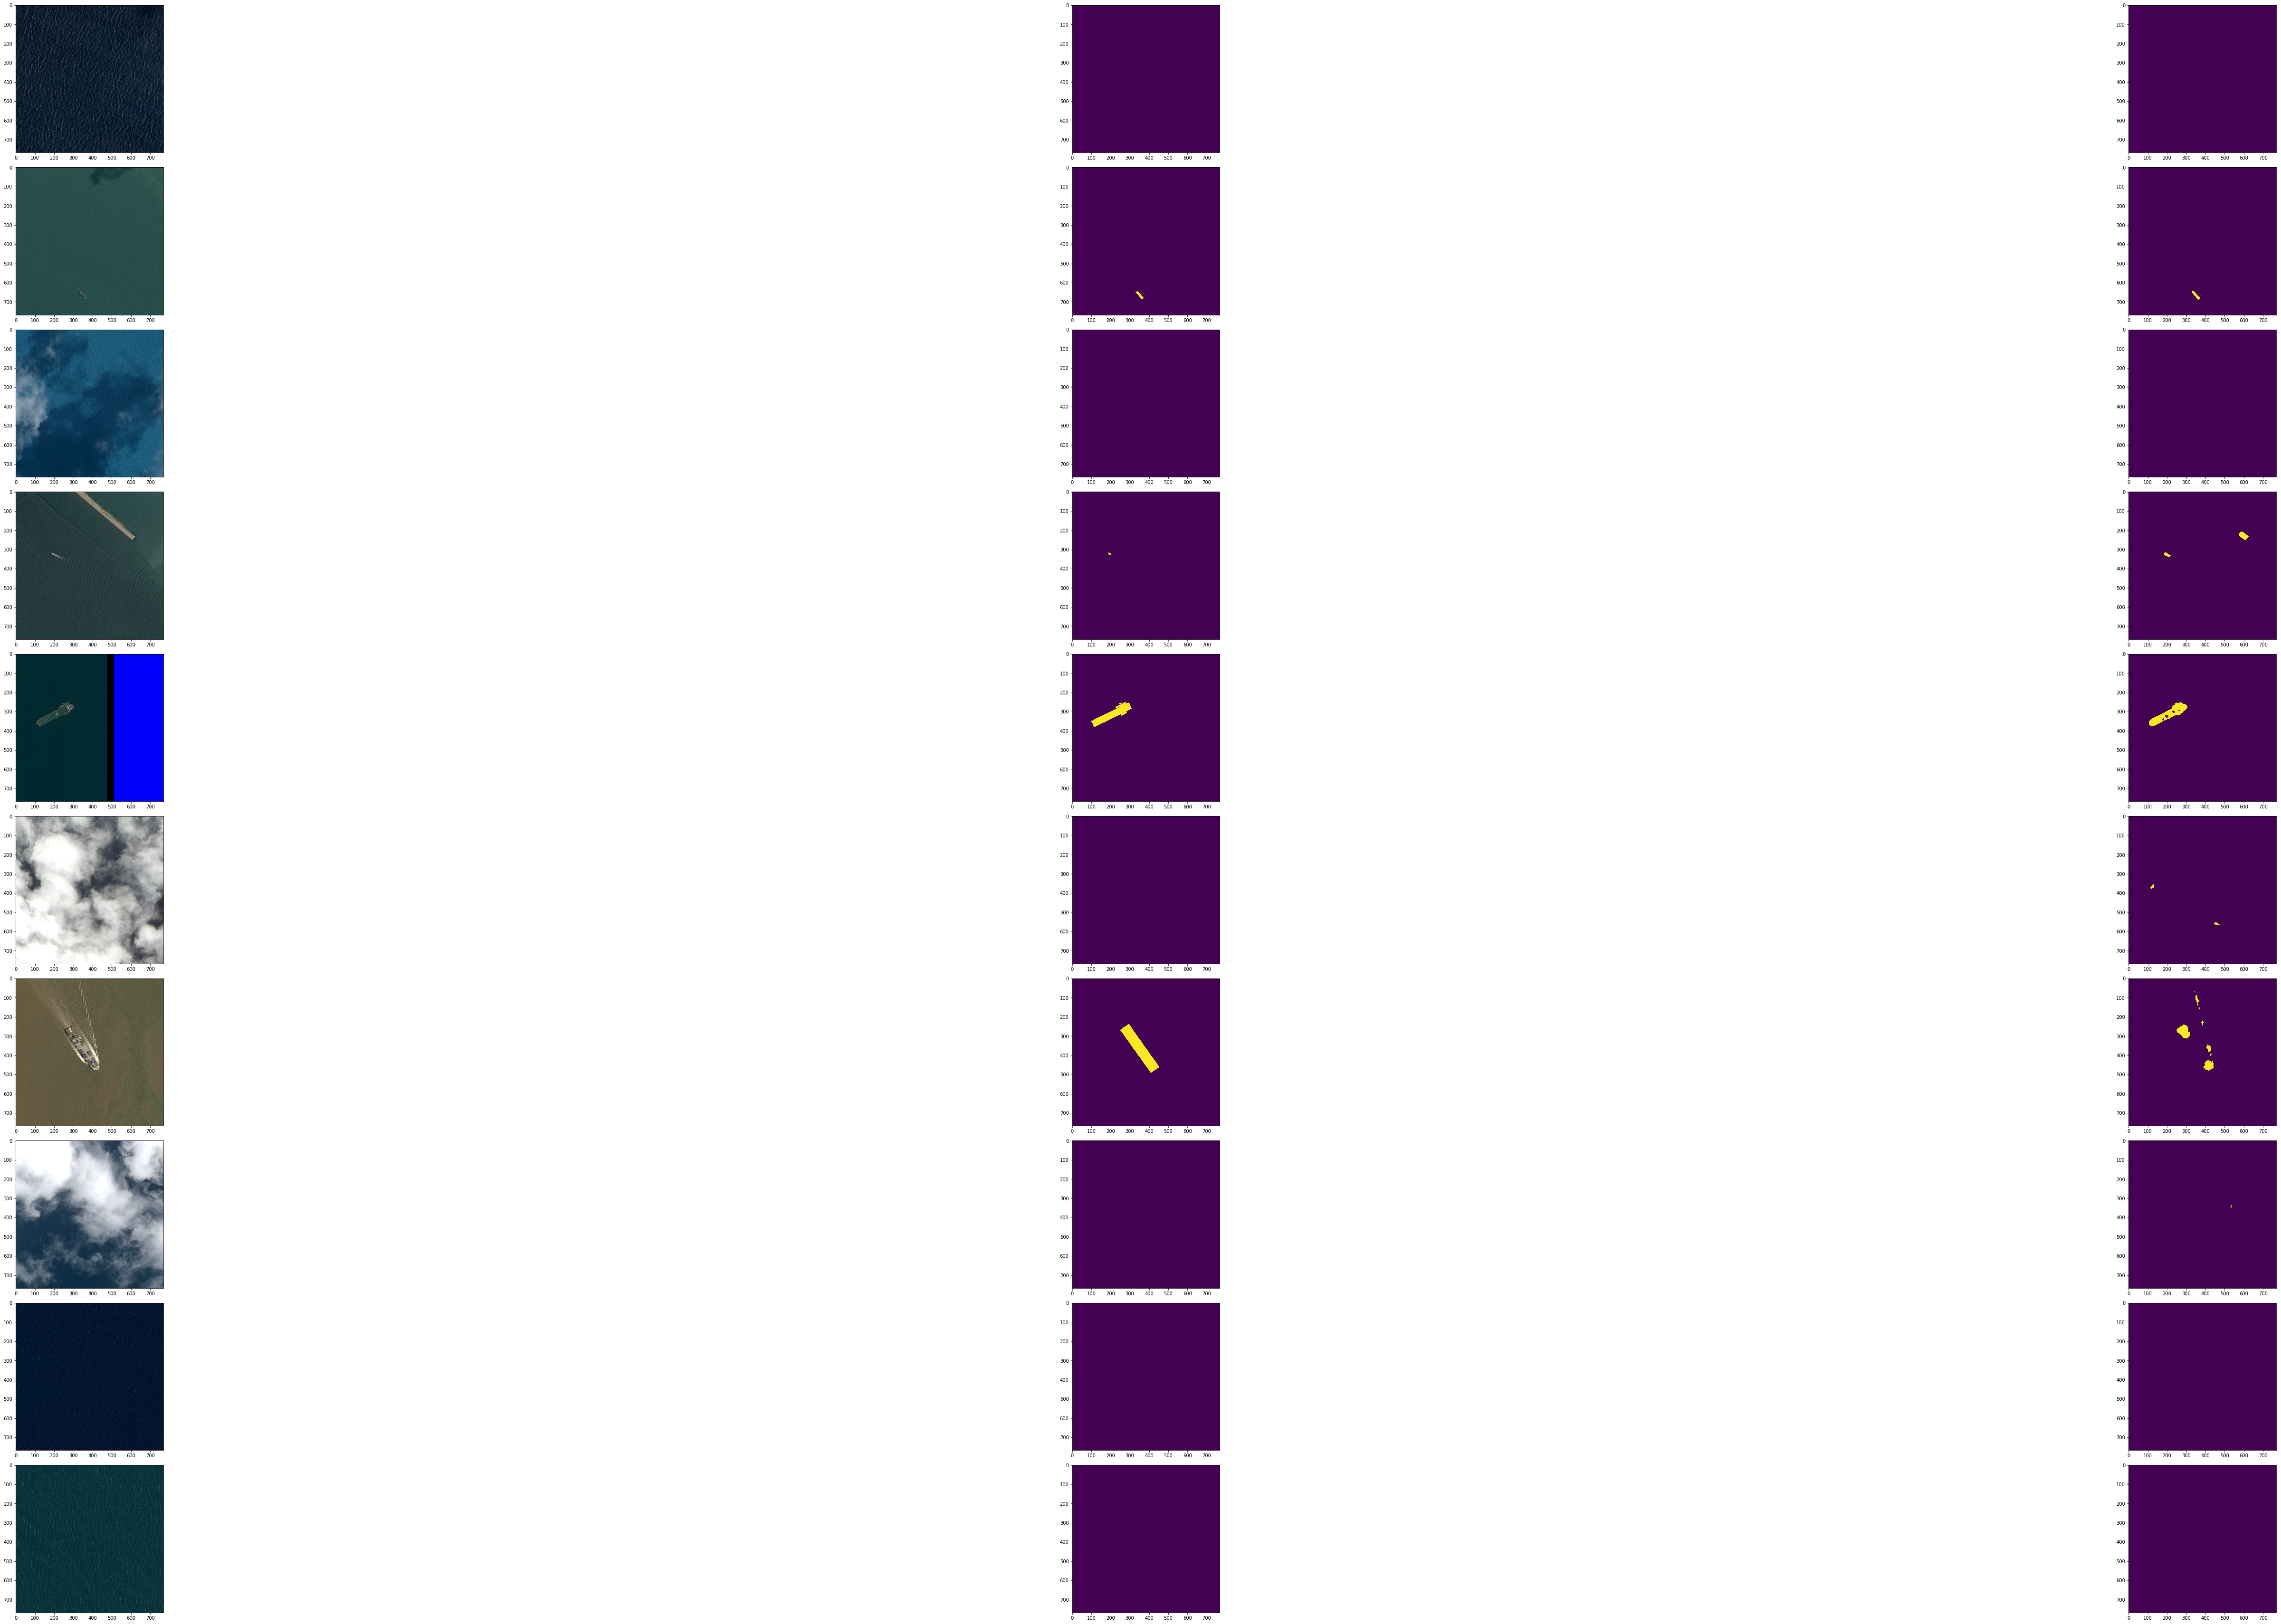

In [54]:
image_list = val_list[20:30]
fig, axes = plt.subplots(len(image_list), 3, figsize=(100,100))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]])
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)

# predict test set and submission with Test Time Augmentation

In [55]:
test_img_names = [x.split('.')[0] for x in os.listdir(test_img_dir)]

In [56]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img[0,:,:,:])
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [57]:
pred_rows = []
for name in tqdm(test_img_names):
    test_img = imread(test_img_dir + name + '.jpg')
    test_img_1 = test_img.reshape(1,768,768,3)/255.0
    test_img_2 = test_img_1[:, :, ::-1, :]
    test_img_3 = test_img_1[:, ::-1, :, :]
    test_img_4 = test_img_1[:, ::-1, ::-1, :]
    pred_prob_1 = model.predict(test_img_1)
    pred_prob_2 = model.predict(test_img_2)
    pred_prob_3 = model.predict(test_img_3)
    pred_prob_4 = model.predict(test_img_4)
    pred_prob = (pred_prob_1 + pred_prob_2[:, :, ::-1, :] + pred_prob_3[:, ::-1, :, :] + pred_prob_4[:, ::-1, ::-1, :])/4
    pred_mask = pred_prob > opt_threshold
    rles = multi_rle_encode(pred_mask)
    if len(rles)>0:
        for rle in rles:
            pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': rle}]
    else:
        pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': None}]

100%|██████████| 15606/15606 [52:00<00:00,  4.93it/s]


In [58]:
submission_df = pd.DataFrame(pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)